# We're going to strip some components off the advanced model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import theano.tensor as tt

import lightkurve as lk
from astropy.units import cds
from astropy import units as u
import seaborn as sns

import corner
import pystan
import pandas as pd
import pickle
import glob
from astropy.io import ascii
import os
import sys

import pymc3 as pm
from pymc3.gp.util import plot_gp_dist
import arviz
import warnings
warnings.filterwarnings('ignore')

cpu = 'bear'

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Build the model

In [2]:
class model():
    def __init__(self, f, n0_, n1_, n2_, deltanu_):
        self.f = f
        self.n0 = n0_
        self.n1 = n1_
        self.n2 = n2_
        self.npts = len(f)
        self.M = [len(n0_), len(n1_), len(n2_)]
        self.deltanu = deltanu_
        
    def epsilon(self, i):
        eps = tt.zeros((3,3))
        eps0 = tt.set_subtensor(eps[0][0], 1.)
        eps1 = tt.set_subtensor(eps[1][0], tt.sqr(tt.cos(i)))
        eps1 = tt.set_subtensor(eps1[1], 0.5 * tt.sqr(tt.sin(i)))
        eps2 = tt.set_subtensor(eps[2][0], 0.25 * tt.sqr((3. * tt.sqr(tt.cos(i)) - 1.)))
        eps2 = tt.set_subtensor(eps2[1], (3./8.) * tt.sqr(tt.sin(2*i)))
        eps2 = tt.set_subtensor(eps2[2], (3./8.) * tt.sin(i)**4)

        eps = tt.set_subtensor(eps[0], eps0)
        eps = tt.set_subtensor(eps[1], eps1)
        eps = tt.set_subtensor(eps[2], eps2)
        
        return eps
            
    def lor(self, freq, h, w):
        return h / (1.0 + 4.0/tt.sqr(w)*tt.sqr((self.f - freq)))
    
    def mode(self, l, freqs, hs, ws, eps, split=0):
        for idx in range(self.M[l]):
            for m in range(-l, l+1, 1):
                self.modes += self.lor(freqs[idx] + (m*split), 
                                     hs[idx] * eps[l,abs(m)], 
                                     ws[idx])
  
    def model(self, p, theano=True):
        f0, f1, f2, g0, g1, g2, h0, h1, h2, split, i, aphi, bphi = p

        # Unpack background parameters
        loga = aphi[0]
        logb = aphi[1]
        logc = aphi[2]
        logd = aphi[3]
        logj = aphi[4]
        logk = aphi[5]
        white = bphi[0]
        scale = bphi[1]
        nyq = bphi[2]
        
        # Calculate the modes
        eps = self.epsilon(i)        
        self.modes = np.zeros(self.npts)
        self.mode(0, f0, h0, g0, eps)
        self.mode(1, f1, h1, g1, eps, split)
        self.mode(2, f2, h2, g2, eps, split)
        self.modes *= self.get_apodization(nyq)
            
        #Calculate the background
        self.back = self.get_background(loga, logb, logc, logd, logj, logk,
                                       white, scale, nyq)            
            
        #Create the model
        self.mod = self.modes + self.back
        if theano:
            return self.mod
        else:
            return self.mod.eval()

    # Small separations are fractional
    def asymptotic(self, n, numax, alpha, epsilon, d=0.): 
        nmax = (numax / self.deltanu) - epsilon
        curve = (alpha/2.)*(n-nmax)*(n-nmax)
        return (n + epsilon + d + curve) * self.deltanu

    def f0(self, p):
        numax, alpha, epsilon, d01, d02 = p
        
        return self.asymptotic(self.n0, numax, alpha, epsilon, 0.)
    
    def f1(self, p):
        numax, alpha, epsilon, d01, d02 = p
        
        return self.asymptotic(self.n1, numax, alpha, epsilon, d01)
    
    def f2(self, p):
        numax, alpha, epsilon, d01, d02 = p
        
        return self.asymptotic(self.n2+1, numax, alpha, epsilon, -d02)

    def gaussian(self, freq, numax, w, A):
        return A * tt.exp(-0.5 * tt.sqr((freq - numax)) / tt.sqr(w))

    def A0(self, f, p, theano=True):
        numax, w, A, V1, V2 = p
        height = self.gaussian(f, numax, w, A)
        if theano:
            return height
        else:
            return height.eval()
    
    def A1(self, f, p, theano=True):
        numax, w, A, V1, V2 = p
        height = self.gaussian(f, numax, w, A)*V1        
        if theano:
            return height
        else:
            return height.eval()
    
    def A2(self, f, p, theano=True):
        numax, w, A, V1, V2 = p
        height = self.gaussian(f, numax, w, A)*V2      
        if theano:
            return height
        else:
            return height.eval()
        
    def harvey(self, a, b, c):
        harvey = 0.9*tt.sqr(a)/b/(1.0 + tt.pow((self.f/b), c))
        return harvey

    def get_apodization(self, nyquist):
        x = (np.pi * self.f) / (2 * nyquist)
        return tt.sqr((tt.sin(x)/x))

    def get_background(self, loga, logb, logc, logd, logj, logk, white, scale, nyq):
        background = np.zeros(len(self.f))
        background += self.get_apodization(nyq) * scale  \
                        * (self.harvey(tt.pow(10, loga), tt.pow(10, logb), 4.) \
                        +  self.harvey(tt.pow(10, logc), tt.pow(10, logd), 4.) \
                        +  self.harvey(tt.pow(10, logj), tt.pow(10, logk), 2.))\
                        +  white
        return background              

### Build the range

In [3]:
nmodes = 10
nbase = 13
n0_ = np.arange(nmodes)+nbase
n1_ = np.copy(n0_)
n2_ = np.copy(n0_) - 1.
fs = .05
nyq = (0.5 * (1./58.6) * u.hertz).to(u.microhertz).value
ff = np.arange(fs, nyq, fs)

### Build the frequencies

In [4]:
deltanu_  =  60.
numax_= 1150.
alpha_ = 0.01
epsilon_ = 1.1
d01_ = deltanu_/2. / deltanu_
d02_ = 6. / deltanu_

In [5]:
mod = model(ff, n0_, n1_, n2_, deltanu_)

In [6]:
init_f = [numax_, alpha_, epsilon_, d01_, d02_]

f0_true = mod.f0(init_f)
f1_true = mod.f1(init_f)
f2_true = mod.f2(init_f)

sigma0_ = 1.5
sigma1_ = 2.0
sigma2_ = .5
f0_ = mod.f0(init_f) + np.random.randn(len(f0_true)) * sigma0_
f1_ = mod.f1(init_f) + np.random.randn(len(f1_true)) * sigma1_
f2_ = mod.f2(init_f) + np.random.randn(len(f2_true)) * sigma2_

In [7]:
lo = f2_.min() - .25*deltanu_
hi = f1_.max() + .25*deltanu_

sel = (ff > lo) & (ff < hi)
f = ff[sel]

### Reset model for new frequency range

In [8]:
mod = model(f, n0_, n1_, n2_, deltanu_)

### Build the linewidths

In [9]:
def kernel(n, rho, L):
    return rho**2 * np.exp(-0.5 * np.subtract.outer(n,n)**2 / L**2)

In [10]:
m_ = .5
c_ = .5
rho_ = 0.1
L_ = 0.3

fs = np.concatenate((f0_, f1_, f2_))
fs -= fs.min()
nf = fs/fs.max()
mu_ = m_ * nf + c_

Sigma_ = kernel(nf, rho_, L_)

lng0_ = np.random.multivariate_normal(mu_, Sigma_)
widths = [np.exp(lng0_)[0:len(f0_)],
          np.exp(lng0_)[len(f0_):len(f0_)+len(f1_)],
          np.exp(lng0_)[len(f0_)+len(f1_):]]

nf_ = nf[:,None]

### Build the mode amplitudes

In [11]:
w_ = (0.25 * numax_)/2.355
V1_ = 1.2
V2_ = 0.7
A_ = 10.
init_h =[numax_,   #numax
         w_,       #envelope width
         A_,       #envelope amplitude
         V1_,      #dipole visibility
         V2_       #ocotopole visibility
        ]
sigmaA_ = .2
amps = [mod.A0(f0_, init_h, theano=False) + np.random.randn(len(f0_)) * sigmaA_,
        mod.A1(f1_, init_h, theano=False) + np.random.randn(len(f0_)) * sigmaA_,
        mod.A2(f2_, init_h, theano=False) + np.random.randn(len(f0_)) * sigmaA_]

INFO (theano.gof.compilelock): Waiting for existing lock by process '10651' (I am process '11141')
INFO:theano.gof.compilelock:Waiting for existing lock by process '10651' (I am process '11141')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/oliver/.theano/compiledir_Linux-5.0--generic-x86_64-with-Ubuntu-19.04-disco-x86_64-3.7.3-64/lock_dir
INFO:theano.gof.compilelock:To manually release the lock, delete /home/oliver/.theano/compiledir_Linux-5.0--generic-x86_64-with-Ubuntu-19.04-disco-x86_64-3.7.3-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '10651' (I am process '11141')
INFO:theano.gof.compilelock:Waiting for existing lock by process '10651' (I am process '11141')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/oliver/.theano/compiledir_Linux-5.0--generic-x86_64-with-Ubuntu-19.04-disco-x86_64-3.7.3-64/lock_dir
INFO:theano.gof.compilelock:To manually release the lock, delete /home/oliver/.theano/co

### Build the background

In [12]:
labels=['loga','logb','logc','logd','logj','logk',
        'white','scale','nyq']
aphi_ =[   1.6,   2.6,   1.6,   3.0,   1.7,   0.5]
bphi_ = [0.4,     1., nyq]
phi_sigma = np.genfromtxt('phi_sigma.txt')
aphi_cholesky = np.linalg.cholesky(phi_sigma[:6,:6])
bphi_sigma = np.sqrt(np.diag(phi_sigma)[6:])

### Construct the model

In [13]:
split_ = 1.
incl_ = np.pi/4.
init_m =[f0_,                         # l0 modes
       f1_,                         # l1 modes
       f2_,                         # l2 modes
       widths[0],             # l0 widths
       widths[1],             # l1 widths
       widths[2],             # l2 widths
       amps[0]**2 * 2.0 / np.pi / widths[0] ,# l0 heights
       amps[1]**2 * 2.0 / np.pi / widths[1] ,# l1 heights
       amps[2]**2 * 2.0 / np.pi / widths[2] ,# l2 heights
       split_,       # splitting
       incl_,                    # inclination angle
       aphi_,                           # background parameters
       bphi_ ]
p = mod.model(init_m, theano=False)*np.random.chisquare(2., size=len(f))/2

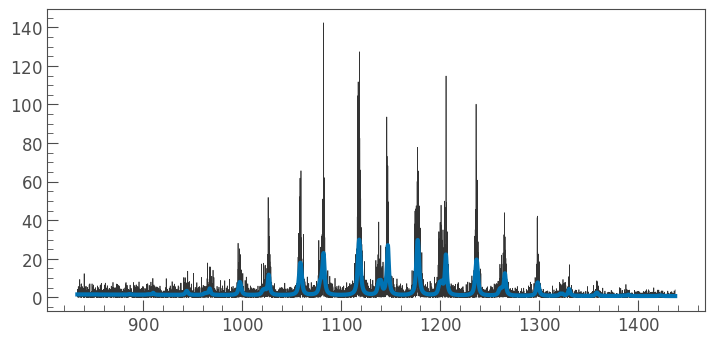

In [14]:
with plt.style.context(lk.MPLSTYLE):
    plt.plot(f, p)
    plt.plot(f, mod.model(init_m, theano=False), lw=3)
#     plt.yscale('log')
#     plt.xscale('log')
    if cpu == 'bear':
        plt.savefig('redata.png')
    else: plt.show()

In [15]:
sys.exit()

SystemExit: 

# Now lets try and fit this

## Building the initial guesses

In [ ]:
init = {}
init['numax'] = numax_
init['alpha'] = alpha_
init['epsilon'] = epsilon_
init['d01'] = d01_
init['d02'] = d02_
init['sigma0'] = sigma0_
init['sigma1'] = sigma1_
init['sigma2'] = sigma2_

init['g0'] = widths[0]
init['g1'] = widths[1]
init['g2'] = widths[2]

init['w'] = w_
init['A'] = A_
init['V1'] = V1_
init['V2'] = V2_
init['sigmaA'] = sigmaA_

init['a0'] = amps[0]
init['a1'] = amps[1]
init['a2'] = amps[2]

init['xsplit'] = split_ * np.sin(incl_)
init['cosi'] = np.cos(incl_)

## Building the model

In [ ]:
pm_model = pm.Model()

with pm_model:   
    # Mode locations
    numax =  pm.Normal('numax', init['numax'], 10., testval = init['numax'])
    alpha =  pm.Normal('alpha', init['alpha'], 0.01, testval = init['alpha'])
    epsilon = pm.Normal('epsilon', init['epsilon'], 1., testval = init['epsilon'])
    d01     = pm.Normal('d01', init['d01'], 0.1, testval = init['d01'])
    d02     = pm.Normal('d02', init['d02'], 0.1, testval = init['d02'])

    sigma0 = pm.HalfCauchy('sigma0', 2., testval = init['sigma0'])
    sigma1 = pm.HalfCauchy('sigma1', 2., testval = init['sigma1'])
    sigma2 = pm.HalfCauchy('sigma2', 2., testval = init['sigma2'])

    f0 = pm.Normal('f0', mod.f0([numax, alpha, epsilon, d01, d02]), sigma0, shape=len(f0_))
    f1 = pm.Normal('f1', mod.f1([numax, alpha, epsilon, d01, d02]), sigma1, shape=len(f1_))
    f2 = pm.Normal('f2', mod.f2([numax, alpha, epsilon, d01, d02]), sigma2, shape=len(f2_))

    # Mode Linewidths
    g0 = pm.HalfNormal('g0', sigma=2.0, shape=len(init['g0']), testval=init['g0'])
    g1 = pm.HalfNormal('g1', sigma=2.0, shape=len(init['g1']), testval=init['g1'])
    g2 = pm.HalfNormal('g2', sigma=2.0, shape=len(init['g2']), testval=init['g2'])

    # Mode Amplitude & Height
    w = pm.Normal('w', init['w'], 10., testval=init['w'])
    A = pm.Normal('A', init['A'], 1., testval=init['A'])
    V1 = pm.Normal('V1', init['V1'], 0.1, testval=init['V1'])
    V2 = pm.Normal('V2', init['V2'], 0.1, testval=init['V2'])

    sigmaA = pm.HalfCauchy('sigmaA', 1., testval = init['sigmaA'])
    Da0 = pm.Normal('Da0',0, 1, shape=len(f0_))
    Da1 = pm.Normal('Da1',0, 1, shape=len(f1_))
    Da2 = pm.Normal('Da2',0, 1, shape=len(f2_))

    a0 = pm.Deterministic('a0', sigmaA * Da0 + mod.A0(f0_, [numax, w, A, V1, V2]))
    a1 = pm.Deterministic('a1', sigmaA * Da1 + mod.A1(f1_, [numax, w, A, V1, V2]))
    a2 = pm.Deterministic('a2', sigmaA * Da2 + mod.A2(f2_, [numax, w, A, V1, V2]))

    h0 = pm.Deterministic('h0', 2*tt.sqr(a0)/np.pi/g0)
    h1 = pm.Deterministic('h1', 2*tt.sqr(a1)/np.pi/g1)
    h2 = pm.Deterministic('h2', 2*tt.sqr(a2)/np.pi/g2)

    # Mode splitting
    xsplit = pm.HalfNormal('xsplit', sigma=2.0, testval = init['xsplit'])
    cosi = pm.Uniform('cosi', 0., 1., testval = init['cosi'])

    i = pm.Deterministic('i', tt.arccos(cosi))
    split = pm.Deterministic('split', xsplit/tt.sin(i))
    
    # Background treatment
    aphi = pm.MvNormal('aphi', mu=aphi_, chol=aphi_cholesky, testval=aphi_, shape=len(aphi_))
    bphi = pm.Normal('bphi', mu=bphi_, sigma=bphi_sigma, testval=bphi_, shape=len(bphi_))
    
    # Construct model
    fit = mod.model([f0, f1, f2, g0, g1, g2, h0, h1, h2, split, i, aphi, bphi])
    
    like = pm.Gamma('like', alpha=1., beta=1./fit, observed=p)

In [ ]:
for RV in pm_model.basic_RVs:
    print(RV.name, RV.logp(pm_model.test_point))

In [ ]:
with pm_model:
    trace = pm.sample(tune=100, draws=100,
                      chains=4,
                      target_accept=.99,
                      start = init,
                      init = 'adapt_diag')

In [ ]:
df = pm.backends.tracetab.trace_to_dataframe(trace)
df.to_csv('retestchains.csv')

In [ ]:
pm.summary(trace)

In [ ]:
labels = ['numax','alpha','epsilon','d01','d02',
          'split','i']
chain = np.array([trace[label] for label in labels])
truths = [numax_, alpha_, epsilon_, d01_, d02_,
         split_, incl_]
corner.corner(chain.T, labels=labels, truths=truths, quantiles=[.16, .5, .84], truth_color='r',show_titles=True)
if cpu == 'bear':
    plt.savefig('recorner1.png')
else: plt.show()

In [ ]:
labels = ['sigma0','sigma1','sigma2','w','A','V1','V2','sigmaA']
chain = np.array([trace[label] for label in labels])
truths = [sigma0_, sigma1_, sigma2_,w_, A_, V1_, V2_, 0.2]
corner.corner(chain.T, labels=labels, truths=truths, quantiles=[.16, .5, .84], truth_color='r',show_titles=True)
if cpu == 'bear':
    plt.savefig('recorner2.png')
else: plt.show()

In [ ]:
with plt.style.context(lk.MPLSTYLE):
    res_m = [np.median(trace[label], axis=0) for label in ['f0','f1','f2','g0','g1','g2',
                                                         'h0','h1','h2','split','i','aphi','bphi']]
    plt.plot(f, p)
    plt.plot(f, mod.model(res_m, theano=False), lw=3)
    if cpu == 'bear':
        plt.savefig('remodelfit.png')
    else: plt.show()
    
    fig, ax = plt.subplots()
    res = [np.median(trace[label]) for label in ['numax', 'w', 'A', 'V1','V2']]
    resls = [np.median(trace[label],axis=0) for label in ['a0','a1','a2']]
       
    ax.plot(f0_, mod.A0(f0_, res,theano=False), label='0 Trend',lw=2, zorder=1)
    ax.plot(f1_, mod.A1(f1_, res,theano=False), label='1 Trend',lw=2, zorder=1)
    ax.plot(f2_, mod.A2(f2_, res,theano=False), label='2 Trend',lw=2, zorder=1)

    ax.scatter(f0_, amps[0], marker='^',label='0 Errd',  s=50, zorder=2)
    ax.scatter(f1_, amps[1], marker='*',label='1 Errd',  s=50, zorder=2)
    ax.scatter(f2_, amps[2], marker='o',label='2 Errd',  s=50, zorder=2)   
  
    ax.plot(f0_, mod.A0(f0_, init_h, theano=False), label='0 Pure',lw=2, zorder=1)
    ax.plot(f1_, mod.A1(f1_, init_h, theano=False), label='1 Pure',lw=2, zorder=1)
    ax.plot(f2_, mod.A2(f2_, init_h, theano=False), label='2 Pure',lw=2, zorder=1)

    ax.scatter(f0_, resls[0], marker='^',label='0 mod', s=10, zorder=3)
    ax.scatter(f1_, resls[1], marker='*',label='1 mod', s=10, zorder=3)
    ax.scatter(f2_, resls[2], marker='o',label='2 mod', s=10, zorder=3)    
    
    ax.legend(loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.3))      
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Amplitude')
    
    if cpu == 'bear':
        plt.savefig('reamplitudefit.png')
    else: plt.show()
    
    fig, ax = plt.subplots()
    res = [np.median(trace[label]) for label in ['numax', 'alpha', 'epsilon','d01','d02']]
    resls = [np.median(trace[label],axis=0) for label in ['f0','f1','f2']]
    stdls = [np.std(trace[label],axis=0) for label in ['f0','f1','f2']]
       
    ax.plot(mod.f0(res)%deltanu_, n0_, label='0 Trend',lw=2, zorder=1)
    ax.plot(mod.f1(res)%deltanu_, n1_, label='1 Trend',lw=2, zorder=1)
    ax.plot(mod.f2(res)%deltanu_, n2_, label='2 Trend',lw=2, zorder=1)

    ax.scatter(f0_%deltanu_, n0_, marker='^',label='0 Truth (glitch)',  s=50, zorder=2)
    ax.scatter(f1_%deltanu_, n1_, marker='*',label='1 Truth (glitch)',  s=50, zorder=2)
    ax.scatter(f2_%deltanu_, n2_, marker='o',label='2 Truth (glitch)',  s=50, zorder=2)   
    
    ax.plot(f0_true%deltanu_, n0_, alpha=.5, label='0 Truth (pure)',  lw=2, zorder=1)
    ax.plot(f1_true%deltanu_, n1_, alpha=.5, label='1 Truth (pure)',  lw=2, zorder=1)
    ax.plot(f2_true%deltanu_, n2_, alpha=.5, label='2 Truth (pure)',  lw=2, zorder=1)      
    
    ax.scatter(resls[0]%deltanu_, n0_, marker='^',label='0 mod', s=10, zorder=3)
    ax.scatter(resls[1]%deltanu_, n1_, marker='*',label='1 mod', s=10, zorder=3)
    ax.scatter(resls[2]%deltanu_, n2_, marker='o',label='2 mod', s=10, zorder=3)    
    
    ax.set_xlabel(r'Frequency mod $\Delta\nu$')
    ax.set_ylabel('Overtone order n')
    ax.legend(loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.3))    
    
    if cpu == 'bear':
        plt.savefig('refrequencyfit.png')
    else: plt.show()    

In [ ]:
with plt.style.context(lk.MPLSTYLE):
    fig, ax = plt.subplots()

    ax.scatter(f0_, widths[0], label='truth', ec='k',s=50,zorder=5)
    ax.scatter(f1_, widths[1], label='truth 1', ec='k',s=50,zorder=5)
    ax.scatter(f2_, widths[2], label='truth 2', ec='k',s=50,zorder=5) 
    
    ax.scatter(f0_, np.median(trace['g0'],axis=0), marker='^', ec='k', label='mod', s=10,zorder=5)
    ax.scatter(f1_, np.median(trace['g1'],axis=0), marker='*', ec='k', label='mod 1', s=10,zorder=5)
    ax.scatter(f2_, np.median(trace['g2'],axis=0), marker='o', ec='k', label='mod 2', s=10,zorder=5)        
    
    ax.errorbar(f0_, np.median(trace['g0'],axis=0), yerr=np.std(trace['g0'],axis=0), fmt='|', c='k', lw=3, alpha=.5)
    ax.errorbar(f1_, np.median(trace['g1'],axis=0), yerr=np.std(trace['g1'],axis=0), fmt='|', c='k', lw=3, alpha=.5)
    ax.errorbar(f2_, np.median(trace['g2'],axis=0), yerr=np.std(trace['g2'],axis=0), fmt='|', c='k', lw=3, alpha=.5)          
     
    ax.legend(loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.3))    
    if cpu == 'bear':
        plt.savefig('widthfit.png')
    else: plt.show()        

In [ ]:
labels=['loga','logb','logc','logd','logj','logk',
        'white','scale','nyq']
verbose=[r'$\log_{10}a$',r'$\log_{10}b$',
        r'$\log_{10}c$',r'$\log_{10}d$',
        r'$\log_{10}j$',r'$\log_{10}k$',
        'white','scale',r'$\nu_{\rm nyq}$']

aphichain = np.array([trace['aphi'][:, idx] for idx in range(len(aphi_))]).T
bphichain = np.array([trace['bphi'][:, idx] for idx in range(len(bphi_))]).T
phichain = np.concatenate((aphichain, bphichain),axis=1)
truth = np.concatenate((aphi_, bphi_))

corner.corner(phichain, truths=truth, show_titles=True, labels=verbose)
if cpu == 'bear':
    plt.savefig('rebackcorner.png')
else: plt.show() 

In [ ]:
residual = p/mod.model(res_m, theano=False)
sns.distplot(residual, label='Model')
sns.distplot(np.random.chisquare(2, size=10000)/2, label=r'Chi22')
plt.legend()

In [ ]:
sys.exit()